### Hipótese
ZCTAs com maior população tendem a gerar um volume maior de exames e, consequentemente, maior receita.

---

In [1]:
# Importando bibliotecas
import warnings
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Carregando os data sets relacionados
transactional_data = pd.read_csv('../../../data/processed/transactional_data_clean.csv')
geocode_data = pd.read_csv('../../../data/processed/geocode_data_clean.csv')
demographic_data = pd.read_csv('../../../data/processed/demographic_data_clean.csv')

In [3]:
# 1. Merge dos dados transacionais com geocode_data para obter o zipcode (ZCTA)
trans_geo = pd.merge(transactional_data, geocode_data[['lab_id', 'zipcode']], on='lab_id', how='left')

trans_geo.head()

,patient_id,gender,dateofbirth,dateofservice,service_id,lab_id,cod_item,testing_cost,zipcode
0,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70003237,9.0,94565.0
1,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70000638,13.0,94565.0
2,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70001597,49.0,94565.0
3,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70000103,11.0,94565.0
4,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70000224,10.0,94565.0


In [4]:
# 2. Agregação dos dados transacionais por zipcode
agg_data = trans_geo.groupby('zipcode').agg(
    volume=('service_id', 'count'),
    revenue=('testing_cost', 'sum')
).reset_index()

agg_data.head()

,zipcode,volume,revenue
0,1605.0,12658,323954.36
1,1606.0,8407,313512.08
2,1701.0,17993,930395.16
3,1702.0,20099,505300.80
4,1840.0,33938,1263382.62


In [5]:
# 3. Merge dos dados agregados com demographic_data para trazer a população total
df_merged = pd.merge(agg_data, demographic_data[['zipcode', 'total_population']], 
                     on='zipcode', how='inner')

# Exibindo dados combinados
df_merged.head()

,zipcode,volume,revenue,total_population
0,1605.0,12658,323954.36,28533
1,1605.0,12658,323954.36,28533
2,1605.0,12658,323954.36,28533
3,1605.0,12658,323954.36,28533
4,1605.0,12658,323954.36,28533


In [6]:
# Removendo os duplicados
df_merged = df_merged.drop_duplicates()

df_merged.head()

,zipcode,volume,revenue,total_population
0,1605.0,12658,323954.36,28533
13,1606.0,8407,313512.08,19896
26,1701.0,17993,930395.16,32590
39,1702.0,20099,505300.80,39799
52,1840.0,33938,1263382.62,5573


In [7]:
# 4. Cálculo da Correlação de Pearson

# Correlação entre total_population e volume de exames
corr_population_volume, p_value_volume = stats.pearsonr(df_merged['total_population'], df_merged['volume'])

# Correlação entre total_population e receita
corr_population_revenue, p_value_revenue = stats.pearsonr(df_merged['total_population'], df_merged['revenue'])

print("\nCorrelação entre total_population e volume de exames:")
print(f"Coeficiente: {corr_population_volume:.3f}, p-valor: {p_value_volume:.3e}")

print("\nCorrelação entre total_population e receita:")
print(f"Coeficiente: {corr_population_revenue:.3f}, p-valor: {p_value_revenue:.3e}")


Correlação entre total_population e volume de exames:
Coeficiente: 0.739, p-valor: 2.646e-18

Correlação entre total_population e receita:
Coeficiente: 0.683, p-valor: 6.671e-15


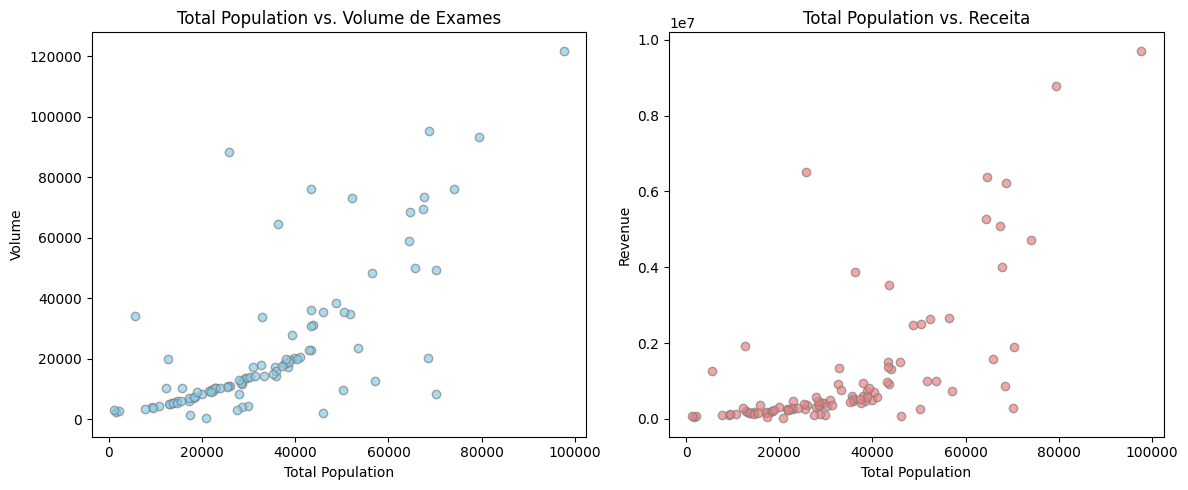

In [8]:
# 5. Visualização dos Resultados
plt.figure(figsize=(12, 5))

# Gráfico de dispersão: População x Volume de Exames
plt.subplot(1, 2, 1)
plt.scatter(df_merged['total_population'], df_merged['volume'], alpha=0.7, edgecolor='gray', color='skyblue')
plt.title('Total Population vs. Volume de Exames')
plt.xlabel('Total Population')
plt.ylabel('Volume')

# Gráfico de dispersão: População x Receita
plt.subplot(1, 2, 2)
plt.scatter(df_merged['total_population'], df_merged['revenue'], alpha=0.7, edgecolor='gray', color='lightcoral')
plt.title('Total Population vs. Receita')
plt.xlabel('Total Population')
plt.ylabel('Revenue')

plt.tight_layout()

---

### Conclusão

Analisando os resultados, é possível confirmar a hipótese de que ZCTAs com maior população tendem a gerar maior volume de exames e receita. Os coeficientes de correlação são robustos: 0.739 para volume de exames e 0.683 para receita, ambos com p-value extremamente baixos (2.646e-18 e 6.671e-15, respectivamente), indicando alta significância estatística.
Os gráficos mostram uma clara tendência positiva, com alguns insights adicionais:

1. A correlação é forte, mas não perfeita, sugerindo que outros fatores além da população influenciam o volume de exames e receita.

2. Existe uma concentração maior de ZCTAs com populações menores (abaixo de 40.000), mas os outliers com populações maiores apresentam volumes e receitas significativamente mais altos.

3. Há alguns ZCTAs que fogem do padrão esperado, gerando volumes ou receitas desproporcionais ao tamanho de sua população, merecendo investigação adicional.

4. A dispersão parece aumentar com o tamanho da população, indicando maior variabilidade nos mercados maiores.

Para a estratégia de expansão, população deve ser considerada como um fator primário, mas não único